# Amazon Product Reviews - Exploratory Data Analysis
## Comprehensive EDA Notebook for Amazon Dataset

## Imports

In [28]:
# Amazon Product Reviews - Exploratory Data Analysis
# Comprehensive EDA Notebook for Amazon Dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import os
import glob
import gzip
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


## Emergency Download

In [29]:
# EMERGENCY DATA DOWNLOAD CELL
# Run this if you get "No CSV files found" error

def emergency_download():
    """Download data directly in the notebook"""
    import requests
    import gzip
    import json
    
    print("🚨 EMERGENCY DATA DOWNLOAD")
    print("Downloading sample Amazon data...")
    
    # Download a small sample directly
    url = "http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Electronics_5.json.gz"
    
    try:
        os.makedirs('data', exist_ok=True)
        
        response = requests.get(url, stream=True)
        with open('data/sample_reviews.json.gz', 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        
        # Extract and convert to CSV
        reviews = []
        with gzip.open('data/sample_reviews.json.gz', 'rt', encoding='utf-8') as f:
            for i, line in enumerate(f):
                if i >= 1000:  # Limit to 1000 reviews for speed
                    break
                if line.strip():
                    try:
                        review = json.loads(line)
                        reviews.append({
                            'reviewerID': review.get('reviewerID', ''),
                            'asin': review.get('asin', ''),
                            'reviewerName': review.get('reviewerName', ''),
                            'helpful': review.get('helpful', [0, 0])[0],
                            'reviewText': review.get('reviewText', ''),
                            'overall': review.get('overall', 0),
                            'summary': review.get('summary', ''),
                            'unixReviewTime': review.get('unixReviewTime', 0),
                            'reviewTime': review.get('reviewTime', ''),
                            'category': 'electronics'
                        })
                    except:
                        continue
        
        df = pd.DataFrame(reviews)
        df.to_csv('data/amazon_reviews_electronics.csv', index=False)
        print(f"✅ Downloaded {len(df)} sample reviews")
        
    except Exception as e:
        print(f"❌ Download failed: {e}")

# Uncomment and run the next line if you need to download data directly in the notebook
# emergency_download()

In [30]:
# 1. Data Preparation - Create database if it doesn't exist
def setup_database():
    """Check if database exists, if not create it from CSV files"""
    
    db_path = 'amazon_reviews.db'
    
    if os.path.exists(db_path):
        print(f"✅ Database already exists: {db_path}")
        return True
    
    print("📥 Database not found. Checking for CSV files...")
    
    # Look for CSV files
    csv_files = glob.glob('data/amazon_reviews_*.csv')
    
    if not csv_files:
        print("❌ No CSV files found in data folder!")
        print("💡 Please run: python data/download_amazon.py")
        return False
    
    print(f"📊 Found {len(csv_files)} CSV files. Creating database...")
    
    try:
        # Create database connection
        conn = sqlite3.connect(db_path)
        
        # Load each CSV file into the database
        for csv_file in csv_files:
            # Extract category name from filename
            category = os.path.basename(csv_file).replace('amazon_reviews_', '').replace('.csv', '')
            table_name = 'reviews'
            
            print(f"   Loading {category} data...")
            df = pd.read_csv(csv_file)
            
            # Add category column if it doesn't exist
            if 'category' not in df.columns:
                df['category'] = category
            
            # Save to database
            df.to_sql(table_name, conn, if_exists='append', index=False)
        
        # Create indexes for better performance
        cursor = conn.cursor()
        indexes = [
            "CREATE INDEX IF NOT EXISTS idx_reviews_asin ON reviews(asin);",
            "CREATE INDEX IF NOT EXISTS idx_reviews_overall ON reviews(overall);",
            "CREATE INDEX IF NOT EXISTS idx_reviews_category ON reviews(category);"
        ]
        
        for index_sql in indexes:
            cursor.execute(index_sql)
        
        conn.commit()
        conn.close()
        
        print(f"✅ Database created successfully: {db_path}")
        
        # Verify the database
        verify_database(db_path)
        return True
        
    except Exception as e:
        print(f"❌ Error creating database: {e}")
        return False

def verify_database(db_path):
    """Verify the database was created correctly"""
    try:
        conn = sqlite3.connect(db_path)
        
        # Check table exists and has data
        tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)
        print("📋 Database tables:", tables['name'].tolist())
        
        # Check record count
        count = pd.read_sql_query("SELECT COUNT(*) as count FROM reviews", conn).iloc[0,0]
        categories = pd.read_sql_query("SELECT category, COUNT(*) as count FROM reviews GROUP BY category", conn)
        
        print(f"📊 Total reviews: {count:,}")
        print("📚 Reviews by category:")
        for _, row in categories.iterrows():
            print(f"   - {row['category']}: {row['count']:,} reviews")
        
        conn.close()
        
    except Exception as e:
        print(f"❌ Error verifying database: {e}")

# Check if we need to download data first
def check_data_files():
    """Check if we have the necessary data files"""
    data_files = glob.glob('data/amazon_reviews_*.csv')
    
    if not data_files:
        print("📥 No data files found. Would you like to download them?")
        print("💡 Run this cell to download:")
        print()
        print("%%bash")
        print("python data/download_amazon.py")
        print()
        return False
    
    print(f"✅ Found {len(data_files)} data files")
    return True

# Main setup function
def setup_environment():
    """Set up the complete environment"""
    print("🚀 SETTING UP AMAZON EDA ENVIRONMENT")
    print("="*50)
    
    # Check for data files
    if not check_data_files():
        return False
    
    # Setup database
    if not setup_database():
        return False
    
    print("✅ Environment setup complete!")
    return True

# Run the setup
environment_ready = setup_environment()

if not environment_ready:
    print("\n❌ Setup incomplete. Please run:")
    print("1. python data/download_amazon.py")
    print("2. Restart this notebook")
else:
    print("\n🎉 Ready for EDA analysis!")

🚀 SETTING UP AMAZON EDA ENVIRONMENT
✅ Found 3 data files
✅ Database already exists: amazon_reviews.db
✅ Environment setup complete!

🎉 Ready for EDA analysis!


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


## SQL Table Creation

In [32]:
# SQLite Database Creation - Demonstrating sqlite3 usage in Python
def create_amazon_database():
    """Create a complete SQLite database with proper schema and data"""
    
    db_path = 'amazon_reviews.db'
    
    # Remove existing database to start fresh
    if os.path.exists(db_path):
        os.remove(db_path)
        print("♻️ Removed existing database")
    
    print("🗃️ CREATING AMAZON REVIEWS SQLITE DATABASE")
    print("="*50)
    
    try:
        # Connect to SQLite database (creates it if doesn't exist)
        conn = sqlite3.connect(db_path)
        cursor = conn.cursor()
        
        print("✅ Database connection established")
        
        # Create tables with proper schema
        print("\n📊 CREATING DATABASE TABLES...")
        
        # Reviews table
        create_reviews_table = """
        CREATE TABLE IF NOT EXISTS reviews (
            reviewerID TEXT,
            asin TEXT,
            reviewerName TEXT,
            helpful INTEGER,
            reviewText TEXT,
            overall REAL,
            summary TEXT,
            unixReviewTime INTEGER,
            reviewTime TEXT,
            category TEXT,
            review_length INTEGER,
            helpful_ratio REAL,
            review_date TEXT,
            PRIMARY KEY (reviewerID, asin, unixReviewTime)
        )
        """
        
        # Products table (if we have product data)
        create_products_table = """
        CREATE TABLE IF NOT EXISTS products (
            asin TEXT PRIMARY KEY,
            title TEXT,
            price REAL,
            brand TEXT,
            categories TEXT,
            description TEXT
        )
        """
        
        # Execute table creation
        cursor.execute(create_reviews_table)
        cursor.execute(create_products_table)
        print("✅ Tables created successfully")
        
        # Load data from CSV files
        print("\n📥 LOADING DATA FROM CSV FILES...")
        
        csv_files = glob.glob('data/amazon_reviews_*.csv')
        
        if not csv_files:
            print("❌ No CSV files found. Please run data download first.")
            return False
        
        total_reviews = 0
        for csv_file in csv_files:
            category = os.path.basename(csv_file).replace('amazon_reviews_', '').replace('.csv', '')
            print(f"   Processing {category}...")
            
            # Read CSV in chunks to handle large files
            chunk_size = 1000
            for chunk in pd.read_csv(csv_file, chunksize=chunk_size):
                # Add category column
                chunk['category'] = category
                
                # Calculate additional fields
                chunk['review_length'] = chunk['reviewText'].str.len().fillna(0)
                chunk['helpful_ratio'] = chunk['helpful'] / (chunk['helpful'] + 1)
                
                # Convert Unix timestamp to readable date
                chunk['review_date'] = pd.to_datetime(chunk['unixReviewTime'], unit='s').dt.strftime('%Y-%m-%d')
                
                # Insert data into database
                chunk.to_sql('reviews', conn, if_exists='append', index=False, method='multi')
                total_reviews += len(chunk)
            
            print(f"   ✅ {category} loaded")
        
        print(f"📊 Total reviews inserted: {total_reviews:,}")
        
        # Create indexes for better performance
        print("\n⚡ CREATING DATABASE INDEXES...")
        
        indexes = [
            "CREATE INDEX idx_reviews_asin ON reviews(asin)",
            "CREATE INDEX idx_reviews_overall ON reviews(overall)",
            "CREATE INDEX idx_reviews_category ON reviews(category)",
            "CREATE INDEX idx_reviews_date ON reviews(review_date)",
            "CREATE INDEX idx_reviews_helpful ON reviews(helpful)",
            "CREATE INDEX idx_products_asin ON products(asin)"
        ]
        
        for index_sql in indexes:
            try:
                cursor.execute(index_sql)
                print(f"   ✅ Index created: {index_sql.split()[-1]}")
            except Exception as e:
                print(f"   ⚠️ Index creation warning: {e}")
        
        # Create views for common queries
        print("\n👁️ CREATING DATABASE VIEWS...")
        
        views = {
            'high_rated_reviews': """
                CREATE VIEW IF NOT EXISTS high_rated_reviews AS
                SELECT * FROM reviews WHERE overall >= 4.0
            """,
            'active_reviewers': """
                CREATE VIEW IF NOT EXISTS active_reviewers AS
                SELECT reviewerID, COUNT(*) as review_count, AVG(overall) as avg_rating
                FROM reviews GROUP BY reviewerID HAVING review_count > 1
            """,
            'product_summary': """
                CREATE VIEW IF NOT EXISTS product_summary AS
                SELECT asin, category, 
                       COUNT(*) as review_count, 
                       AVG(overall) as avg_rating,
                       AVG(review_length) as avg_review_length
                FROM reviews GROUP BY asin, category
            """
        }
        
        for view_name, view_sql in views.items():
            try:
                cursor.execute(view_sql)
                print(f"   ✅ View created: {view_name}")
            except Exception as e:
                print(f"   ⚠️ View creation warning: {e}")
        
        # Commit changes and close connection
        conn.commit()
        conn.close()
        
        print(f"\n🎉 DATABASE CREATION COMPLETE!")
        print(f"📁 Database file: {db_path}")
        print(f"📊 Total records: {total_reviews:,}")
        
        return True
        
    except Exception as e:
        print(f"❌ Error creating database: {e}")
        return False

def demonstrate_sql_queries():
    """Demonstrate various SQL queries on the database"""
    
    print("\n🔍 DEMONSTRATING SQL QUERIES")
    print("="*50)
    
    conn = sqlite3.connect('amazon_reviews.db')
    
    # Query 1: Basic aggregation
    print("1. BASIC DATABASE STATS:")
    basic_stats = pd.read_sql_query("""
        SELECT 
            COUNT(*) as total_reviews,
            COUNT(DISTINCT asin) as unique_products,
            COUNT(DISTINCT reviewerID) as unique_reviewers,
            AVG(overall) as avg_rating,
            MIN(overall) as min_rating,
            MAX(overall) as max_rating
        FROM reviews
    """, conn)
    
    display(basic_stats)
    
    # Query 2: Rating distribution
    print("\n2. RATING DISTRIBUTION:")
    rating_dist = pd.read_sql_query("""
        SELECT 
            overall as rating,
            COUNT(*) as count,
            ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM reviews), 2) as percentage
        FROM reviews
        GROUP BY overall
        ORDER BY overall DESC
    """, conn)
    
    display(rating_dist)
    
    # Query 3: Category performance
    print("\n3. CATEGORY PERFORMANCE:")
    category_stats = pd.read_sql_query("""
        SELECT 
            category,
            COUNT(*) as review_count,
            COUNT(DISTINCT asin) as product_count,
            AVG(overall) as avg_rating,
            AVG(review_length) as avg_review_length
        FROM reviews
        GROUP BY category
        ORDER BY review_count DESC
    """, conn)
    
    display(category_stats)
    
    # Query 4: Using the created view
    print("\n4. ACTIVE REVIEWERS (Using SQL View):")
    active_reviewers = pd.read_sql_query("""
        SELECT * FROM active_reviewers 
        ORDER BY review_count DESC 
        LIMIT 10
    """, conn)
    
    display(active_reviewers)
    
    # Query 5: Complex join example (if we had products table)
    try:
        print("\n5. PRODUCT ANALYSIS (If products data available):")
        product_analysis = pd.read_sql_query("""
            SELECT 
                r.category,
                COUNT(DISTINCT r.asin) as product_count,
                AVG(r.overall) as avg_rating
            FROM reviews r
            GROUP BY r.category
            ORDER BY product_count DESC
        """, conn)
        
        display(product_analysis)
    except:
        print("   ℹ️ Products table not available (this is normal)")
    
    conn.close()
    
    print("\n✅ SQL Query Demonstration Complete!")

def database_management_demo():
    """Demonstrate database management operations"""
    
    print("\n⚙️ DATABASE MANAGEMENT OPERATIONS")
    print("="*50)
    
    conn = sqlite3.connect('amazon_reviews.db')
    cursor = conn.cursor()
    
    # Show database schema
    print("1. DATABASE SCHEMA:")
    tables = cursor.execute("SELECT name FROM sqlite_master WHERE type='table'").fetchall()
    for table in tables:
        table_name = table[0]
        print(f"\n📊 Table: {table_name}")
        columns = cursor.execute(f"PRAGMA table_info({table_name})").fetchall()
        for col in columns:
            print(f"   - {col[1]} ({col[2]})")
    
    # Show indexes
    print("\n2. DATABASE INDEXES:")
    indexes = cursor.execute("SELECT name, sql FROM sqlite_master WHERE type='index'").fetchall()
    for idx in indexes:
        print(f"   📈 {idx[0]}")
    
    # Show views
    print("\n3. DATABASE VIEWS:")
    views = cursor.execute("SELECT name, sql FROM sqlite_master WHERE type='view'").fetchall()
    for view in views:
        print(f"   👁️ {view[0]}")
    
    # Database size info
    print("\n4. DATABASE SIZE INFORMATION:")
    size_info = cursor.execute("""
        SELECT 
            name as table_name,
            (SELECT COUNT(*) FROM reviews) as row_count,
            (page_count * page_size) / 1024 / 1024.0 as size_mb
        FROM sqlite_master, pragma_page_count(), pragma_page_size()
        WHERE type='table' AND name='reviews'
    """).fetchone()
    
    if size_info:
        print(f"   📁 Table: {size_info[0]}")
        print(f"   📊 Rows: {size_info[1]:,}")
        print(f"   💾 Size: {size_info[2]:.2f} MB")
    
    conn.close()

# Main database setup function
def setup_complete_database():
    """Complete database setup and demonstration"""
    
    print("🚀 COMPLETE SQLITE DATABASE SETUP")
    print("="*60)
    
    # Create the database
    if create_amazon_database():
        # Demonstrate SQL queries
        demonstrate_sql_queries()
        
        # Show database management
        database_management_demo()
        
        print("\n🎉 DATABASE SETUP AND DEMONSTRATION COMPLETE!")
        return True
    else:
        print("❌ Database setup failed")
        return False

# Run the complete database setup
database_ready = setup_complete_database()

🚀 COMPLETE SQLITE DATABASE SETUP
♻️ Removed existing database
🗃️ CREATING AMAZON REVIEWS SQLITE DATABASE
✅ Database connection established

📊 CREATING DATABASE TABLES...
✅ Tables created successfully

📥 LOADING DATA FROM CSV FILES...
   Processing books...
   ✅ books loaded
   Processing electronics...
   ✅ electronics loaded
   Processing movies_tv...
   ✅ movies_tv loaded
📊 Total reviews inserted: 30,000

⚡ CREATING DATABASE INDEXES...
   ✅ Index created: reviews(asin)
   ✅ Index created: reviews(overall)
   ✅ Index created: reviews(category)
   ✅ Index created: reviews(review_date)
   ✅ Index created: reviews(helpful)
   ✅ Index created: products(asin)

👁️ CREATING DATABASE VIEWS...
   ✅ View created: high_rated_reviews
   ✅ View created: active_reviewers
   ✅ View created: product_summary

🎉 DATABASE CREATION COMPLETE!
📁 Database file: amazon_reviews.db
📊 Total records: 30,000

🔍 DEMONSTRATING SQL QUERIES
1. BASIC DATABASE STATS:


,total_reviews,unique_products,unique_reviewers,avg_rating,min_rating,max_rating
0,30000,746,25198,4.243233,1.0,5.0



2. RATING DISTRIBUTION:


,rating,count,percentage
0,5.0,17805,59.35
1,4.0,6294,20.98
2,3.0,2823,9.41
3,2.0,1549,5.16
4,1.0,1529,5.10



3. CATEGORY PERFORMANCE:


,category,review_count,product_count,avg_rating,avg_review_length
0,books,10000,175,4.1584,818.8378
1,electronics,10000,406,4.2623,617.4008
2,movies_tv,10000,165,4.3090,939.3374



4. ACTIVE REVIEWERS (Using SQL View):


,reviewerID,review_count,avg_rating
0,A231WM2Z2JL0U3,23,4.565217
1,ANCOMAI0I7LVG,23,3.608696
2,A1MJMYLRTZ76ZX,20,4.500000
3,A1X054KUYG5V,17,3.588235
4,A7Y6AVS576M03,17,4.764706
5,A35ZK3M8L9JUPX,16,5.000000
6,A1JH5J1KQAUBMP,15,3.933333
7,A1NVD0TKNS1GT5,14,4.214286
8,A2TXR85WQLE32N,14,4.285714
9,A10ODC971MDHV8,13,5.000000



5. PRODUCT ANALYSIS (If products data available):


,category,product_count,avg_rating
0,electronics,406,4.2623
1,books,175,4.1584
2,movies_tv,165,4.3090



✅ SQL Query Demonstration Complete!

⚙️ DATABASE MANAGEMENT OPERATIONS
1. DATABASE SCHEMA:

📊 Table: reviews
   - reviewerID (TEXT)
   - asin (TEXT)
   - reviewerName (TEXT)
   - helpful (INTEGER)
   - reviewText (TEXT)
   - overall (REAL)
   - summary (TEXT)
   - unixReviewTime (INTEGER)
   - reviewTime (TEXT)
   - category (TEXT)
   - review_length (INTEGER)
   - helpful_ratio (REAL)
   - review_date (TEXT)

📊 Table: products
   - asin (TEXT)
   - title (TEXT)
   - price (REAL)
   - brand (TEXT)
   - categories (TEXT)
   - description (TEXT)

2. DATABASE INDEXES:
   📈 sqlite_autoindex_reviews_1
   📈 sqlite_autoindex_products_1
   📈 idx_reviews_asin
   📈 idx_reviews_overall
   📈 idx_reviews_category
   📈 idx_reviews_date
   📈 idx_reviews_helpful
   📈 idx_products_asin

3. DATABASE VIEWS:
   👁️ high_rated_reviews
   👁️ active_reviewers
   👁️ product_summary

4. DATABASE SIZE INFORMATION:
   📁 Table: reviews
   📊 Rows: 30,000
   💾 Size: 34.79 MB

🎉 DATABASE SETUP AND DEMONSTRATION COMP

## 1. Data Loading and Initial Setup

In [33]:
# Data Loading (now that database is guaranteed to be properly set up)
def load_data_from_database():
    """Load data from the properly created SQLite database"""
    
    if not database_ready:
        print("❌ Database not ready. Please run setup first.")
        return None, None
    
    try:
        conn = sqlite3.connect('amazon_reviews.db')
        
        print("📊 LOADING DATA FOR EDA ANALYSIS...")
        print("="*40)
        
        # Load reviews with sample for EDA
        reviews_query = """
        SELECT * FROM reviews 
        ORDER BY RANDOM() 
        LIMIT 10000  -- Limit for manageable EDA
        """
        
        reviews_df = pd.read_sql_query(reviews_query, conn)
        
        # Try to load products if available
        try:
            products_df = pd.read_sql_query("SELECT * FROM products LIMIT 1000", conn)
            print(f"✅ Loaded {len(products_df)} products")
        except:
            products_df = None
            print("ℹ️ No products table available")
        
        conn.close()
        
        print(f"✅ Loaded {len(reviews_df):,} reviews for EDA")
        
        # Basic info
        print(f"📋 Sample size: {len(reviews_df):,} reviews")
        print(f"📅 Date range in sample: {reviews_df['review_date'].min()} to {reviews_df['review_date'].max()}")
        print(f"⭐ Rating range: {reviews_df['overall'].min()} to {reviews_df['overall'].max()}")
        
        return reviews_df, products_df
        
    except Exception as e:
        print(f"❌ Error loading data: {e}")
        return None, None

# Load the data
reviews_df, products_df = load_data_from_database()

if reviews_df is not None:
    print("\n🔍 SAMPLE DATA PREVIEW:")
    display(reviews_df[['reviewerID', 'asin', 'overall', 'category', 'review_date', 'review_length']].head())
else:
    print("❌ Failed to load data")

📊 LOADING DATA FOR EDA ANALYSIS...
✅ Loaded 0 products
✅ Loaded 10,000 reviews for EDA
📋 Sample size: 10,000 reviews
📅 Date range in sample: 1997-09-21 to 2014-07-20
⭐ Rating range: 1.0 to 5.0

🔍 SAMPLE DATA PREVIEW:


,reviewerID,asin,overall,category,review_date,review_length
0,AHRWSHIMCV963,B00000J1SC,4.0,electronics,2013-08-12,231
1,A2FC3ME27RF1N,B00004T8R2,5.0,electronics,2007-07-14,158
2,A246IM7MP7YZ8K,B00003ZDJ7,5.0,electronics,2013-04-03,59
3,A1H1WE211BQL7F,B00004TWM6,2.0,electronics,2012-10-18,212
4,A1S4E1QSHSAD8O,0767726227,4.0,movies_tv,2012-07-30,630


## 2. Data Preprocessing and Cleaning

In [34]:
# Data cleaning and preprocessing
def preprocess_data(reviews_df):
    """Clean and preprocess the reviews data"""
    
    print("🧹 Data Preprocessing...")
    print("="*50)
    
    # Create a copy to avoid modifying original
    df = reviews_df.copy()
    
    # Convert Unix timestamp to datetime
    df['review_date'] = pd.to_datetime(df['unixReviewTime'], unit='s')
    df['review_year'] = df['review_date'].dt.year
    df['review_month'] = df['review_date'].dt.to_period('M')
    
    # Calculate review length
    df['review_length'] = df['reviewText'].str.len().fillna(0)
    
    # Create helpfulness ratio
    df['helpful_ratio'] = df['helpful'] / (df['helpful'] + 1)  # Add 1 to avoid division by zero
    
    # Create rating categories
    df['rating_category'] = pd.cut(df['overall'], 
                                  bins=[0, 1, 2, 3, 4, 5], 
                                  labels=['1★', '2★', '3★', '4★', '5★'],
                                  include_lowest=True)
    
    print("✅ Data preprocessing completed!")
    print(f"   - Added review_date, review_year, review_month")
    print(f"   - Added review_length and helpful_ratio")
    print(f"   - Created rating categories")
    
    return df

# Preprocess the data
if reviews_df is not None:
    clean_df = preprocess_data(reviews_df)
    display(clean_df[['overall', 'rating_category', 'review_length', 'helpful_ratio', 'review_date']].head(3))

🧹 Data Preprocessing...
✅ Data preprocessing completed!
   - Added review_date, review_year, review_month
   - Added review_length and helpful_ratio
   - Created rating categories


,overall,rating_category,review_length,helpful_ratio,review_date
0,4.0,4★,231.0,0.0,2013-08-12
1,5.0,5★,158.0,0.0,2007-07-14
2,5.0,5★,59.0,0.0,2013-04-03


## 3. Basic Statistics and Data Quality Check

In [35]:
# Basic statistics and data quality
def data_quality_report(df):
    """Generate data quality report"""
    
    print("📈 DATA QUALITY REPORT")
    print("="*60)
    
    # Basic statistics
    print("1. BASIC STATISTICS:")
    print("-" * 30)
    print(f"Total records: {len(df):,}")
    print(f"Date range: {df['review_date'].min()} to {df['review_date'].max()}")
    print(f"Unique products: {df['asin'].nunique():,}")
    print(f"Unique reviewers: {df['reviewerID'].nunique():,}")
    print(f"Unique categories: {df['category'].nunique()}")
    
    # Missing values
    print("\n2. MISSING VALUES:")
    print("-" * 30)
    missing_data = df.isnull().sum()
    for col, missing in missing_data.items():
        if missing > 0:
            print(f"{col}: {missing:,} ({missing/len(df)*100:.2f}%)")
    
    # Rating distribution
    print("\n3. RATING DISTRIBUTION:")
    print("-" * 30)
    rating_stats = df['overall'].describe()
    print(rating_stats)
    
    return missing_data

# Generate data quality report
if 'clean_df' in locals():
    missing_data = data_quality_report(clean_df)

📈 DATA QUALITY REPORT
1. BASIC STATISTICS:
------------------------------
Total records: 10,000
Date range: 1997-09-21 00:00:00 to 2014-07-20 00:00:00
Unique products: 713
Unique reviewers: 9,188
Unique categories: 3

2. MISSING VALUES:
------------------------------
reviewerName: 32 (0.32%)
reviewText: 2 (0.02%)

3. RATING DISTRIBUTION:
------------------------------
count    10000.000000
mean         4.242300
std          1.142069
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: overall, dtype: float64


## 4. Ratin Analysis

⭐ RATING ANALYSIS


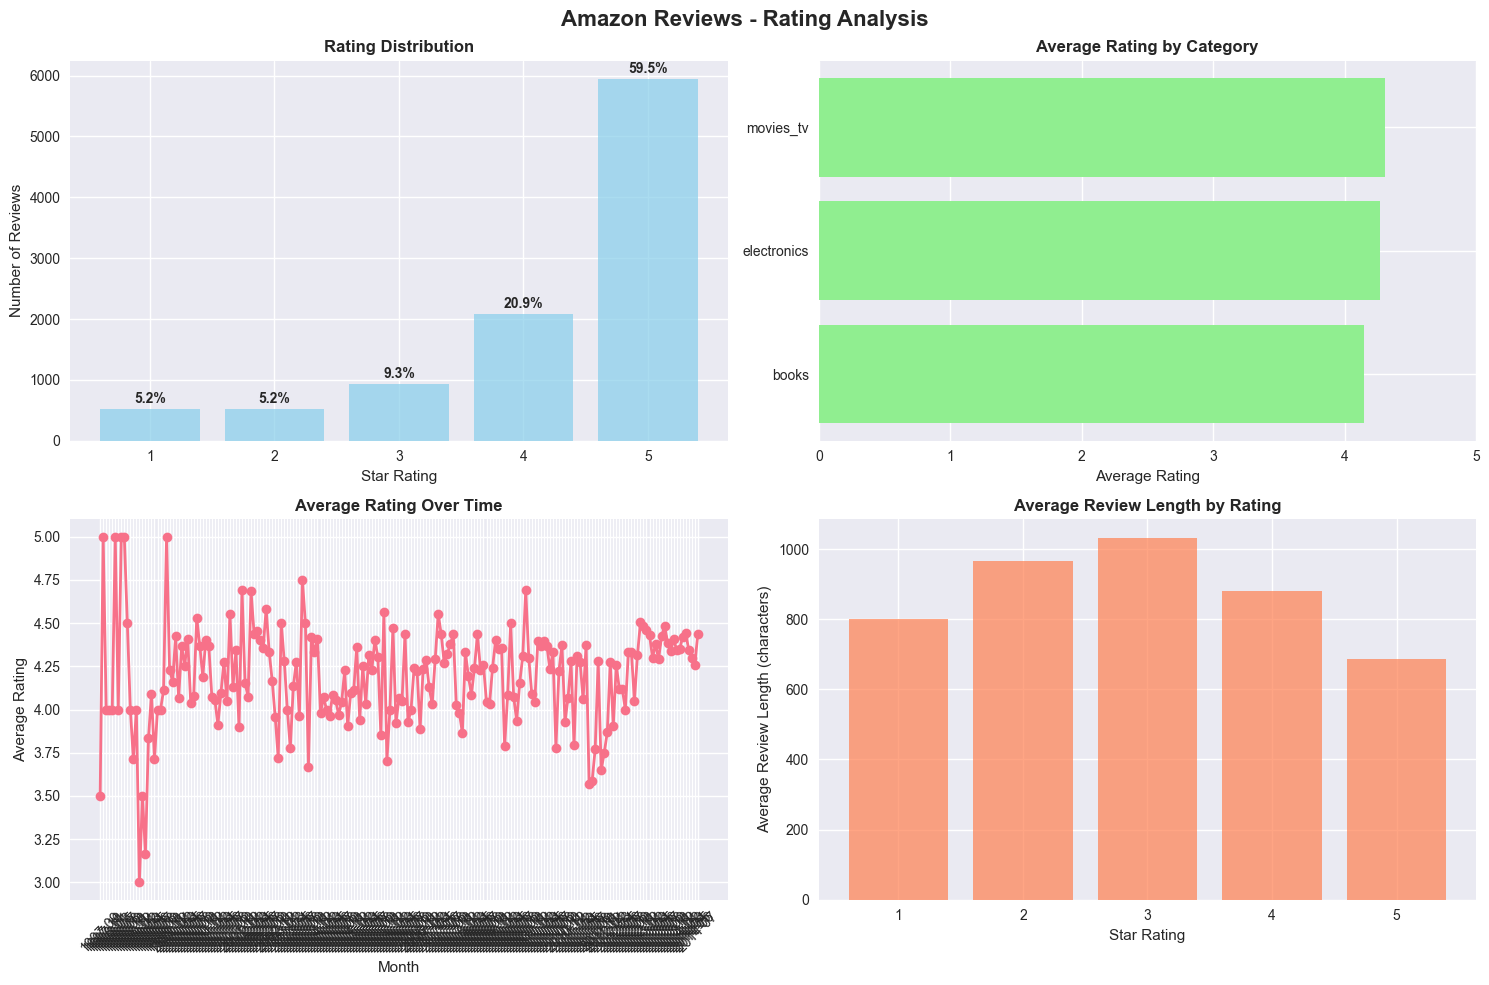


💡 KEY INSIGHTS:
------------------------------
• Most common rating: 5.0 stars (59.5%)
• Average rating: 4.24/5.0
• Highest rated category: movies_tv (4.31)
• Lowest rated category: books (4.15)


In [36]:
# Rating analysis
def analyze_ratings(df):
    """Comprehensive rating analysis"""
    
    print("⭐ RATING ANALYSIS")
    print("="*50)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Amazon Reviews - Rating Analysis', fontsize=16, fontweight='bold')
    
    # 1. Rating distribution
    rating_dist = df['overall'].value_counts().sort_index()
    axes[0,0].bar(rating_dist.index, rating_dist.values, color='skyblue', alpha=0.7)
    axes[0,0].set_title('Rating Distribution', fontweight='bold')
    axes[0,0].set_xlabel('Star Rating')
    axes[0,0].set_ylabel('Number of Reviews')
    axes[0,0].set_xticks(range(1, 6))
    
    # Add percentage labels
    total = len(df)
    for i, v in enumerate(rating_dist.values):
        axes[0,0].text(rating_dist.index[i], v + total*0.01, 
                      f'{v/total*100:.1f}%', ha='center', fontweight='bold')
    
    # 2. Rating distribution by category
    category_ratings = df.groupby('category')['overall'].agg(['mean', 'count']).sort_values('count', ascending=False)
    axes[0,1].barh(category_ratings.index, category_ratings['mean'], color='lightgreen')
    axes[0,1].set_title('Average Rating by Category', fontweight='bold')
    axes[0,1].set_xlabel('Average Rating')
    axes[0,1].set_xlim(0, 5)
    
    # 3. Rating trends over time
    monthly_ratings = df.groupby('review_month')['overall'].mean().reset_index()
    monthly_ratings['review_month'] = monthly_ratings['review_month'].astype(str)
    axes[1,0].plot(monthly_ratings['review_month'], monthly_ratings['overall'], marker='o', linewidth=2)
    axes[1,0].set_title('Average Rating Over Time', fontweight='bold')
    axes[1,0].set_xlabel('Month')
    axes[1,0].set_ylabel('Average Rating')
    axes[1,0].tick_params(axis='x', rotation=45)
    
    # 4. Rating vs review length
    rating_length = df.groupby('overall')['review_length'].mean()
    axes[1,1].bar(rating_length.index, rating_length.values, color='coral', alpha=0.7)
    axes[1,1].set_title('Average Review Length by Rating', fontweight='bold')
    axes[1,1].set_xlabel('Star Rating')
    axes[1,1].set_ylabel('Average Review Length (characters)')
    axes[1,1].set_xticks(range(1, 6))
    
    plt.tight_layout()
    plt.show()
    
    # Print key insights
    print("\n💡 KEY INSIGHTS:")
    print("-" * 30)
    print(f"• Most common rating: {rating_dist.idxmax()} stars ({rating_dist.max()/total*100:.1f}%)")
    print(f"• Average rating: {df['overall'].mean():.2f}/5.0")
    print(f"• Highest rated category: {category_ratings['mean'].idxmax()} ({category_ratings['mean'].max():.2f})")
    print(f"• Lowest rated category: {category_ratings['mean'].idxmin()} ({category_ratings['mean'].min():.2f})")
    
    return rating_dist, category_ratings

# Run rating analysis
if 'clean_df' in locals():
    rating_dist, category_ratings = analyze_ratings(clean_df)

## 5. Temporal Analysis

📅 TEMPORAL ANALYSIS


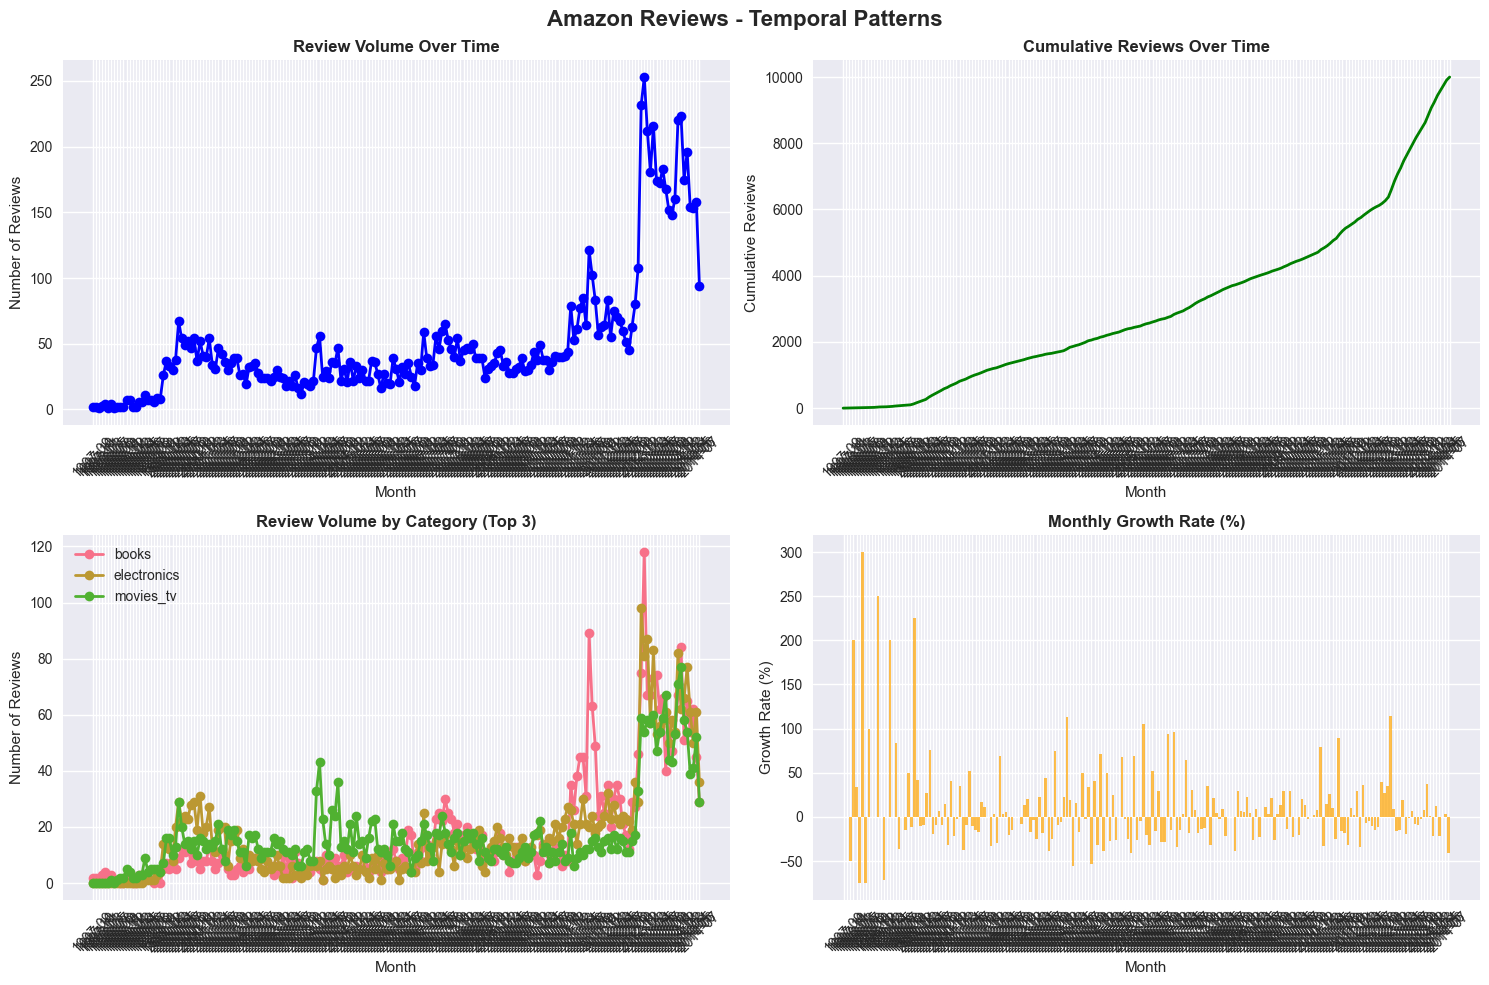


💡 TEMPORAL INSIGHTS:
------------------------------
• Peak review month: 2013-01 (253 reviews)
• Total growth period: 199 months
• Average monthly reviews: 50
• Maximum monthly growth: 300.0%


In [37]:
# Temporal analysis
def analyze_temporal_patterns(df):
    """Analyze review patterns over time"""
    
    print("📅 TEMPORAL ANALYSIS")
    print("="*50)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Amazon Reviews - Temporal Patterns', fontsize=16, fontweight='bold')
    
    # 1. Reviews over time
    monthly_reviews = df.groupby('review_month').size()
    monthly_reviews.index = monthly_reviews.index.astype(str)
    
    axes[0,0].plot(monthly_reviews.index, monthly_reviews.values, marker='o', linewidth=2, color='blue')
    axes[0,0].set_title('Review Volume Over Time', fontweight='bold')
    axes[0,0].set_xlabel('Month')
    axes[0,0].set_ylabel('Number of Reviews')
    axes[0,0].tick_params(axis='x', rotation=45)
    
    # 2. Cumulative reviews
    cumulative_reviews = monthly_reviews.cumsum()
    axes[0,1].plot(cumulative_reviews.index, cumulative_reviews.values, linewidth=2, color='green')
    axes[0,1].set_title('Cumulative Reviews Over Time', fontweight='bold')
    axes[0,1].set_xlabel('Month')
    axes[0,1].set_ylabel('Cumulative Reviews')
    axes[0,1].tick_params(axis='x', rotation=45)
    
    # 3. Reviews by category over time
    category_monthly = df.groupby(['review_month', 'category']).size().unstack().fillna(0)
    category_monthly.index = category_monthly.index.astype(str)
    
    # Plot top 3 categories
    top_categories = df['category'].value_counts().head(3).index
    for category in top_categories:
        if category in category_monthly.columns:
            axes[1,0].plot(category_monthly.index, category_monthly[category], 
                          marker='o', label=category, linewidth=2)
    
    axes[1,0].set_title('Review Volume by Category (Top 3)', fontweight='bold')
    axes[1,0].set_xlabel('Month')
    axes[1,0].set_ylabel('Number of Reviews')
    axes[1,0].tick_params(axis='x', rotation=45)
    axes[1,0].legend()
    
    # 4. Monthly growth rate
    growth_rate = monthly_reviews.pct_change().fillna(0) * 100
    axes[1,1].bar(growth_rate.index, growth_rate.values, color='orange', alpha=0.7)
    axes[1,1].set_title('Monthly Growth Rate (%)', fontweight='bold')
    axes[1,1].set_xlabel('Month')
    axes[1,1].set_ylabel('Growth Rate (%)')
    axes[1,1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Print insights
    print("\n💡 TEMPORAL INSIGHTS:")
    print("-" * 30)
    print(f"• Peak review month: {monthly_reviews.idxmax()} ({monthly_reviews.max():,} reviews)")
    print(f"• Total growth period: {len(monthly_reviews)} months")
    print(f"• Average monthly reviews: {monthly_reviews.mean():.0f}")
    print(f"• Maximum monthly growth: {growth_rate.max():.1f}%")
    
    return monthly_reviews, growth_rate

# Run temporal analysis
if 'clean_df' in locals():
    monthly_reviews, growth_rate = analyze_temporal_patterns(clean_df)

## 6. Reviewer Behavior Analysis

👥 REVIEWER BEHAVIOR ANALYSIS


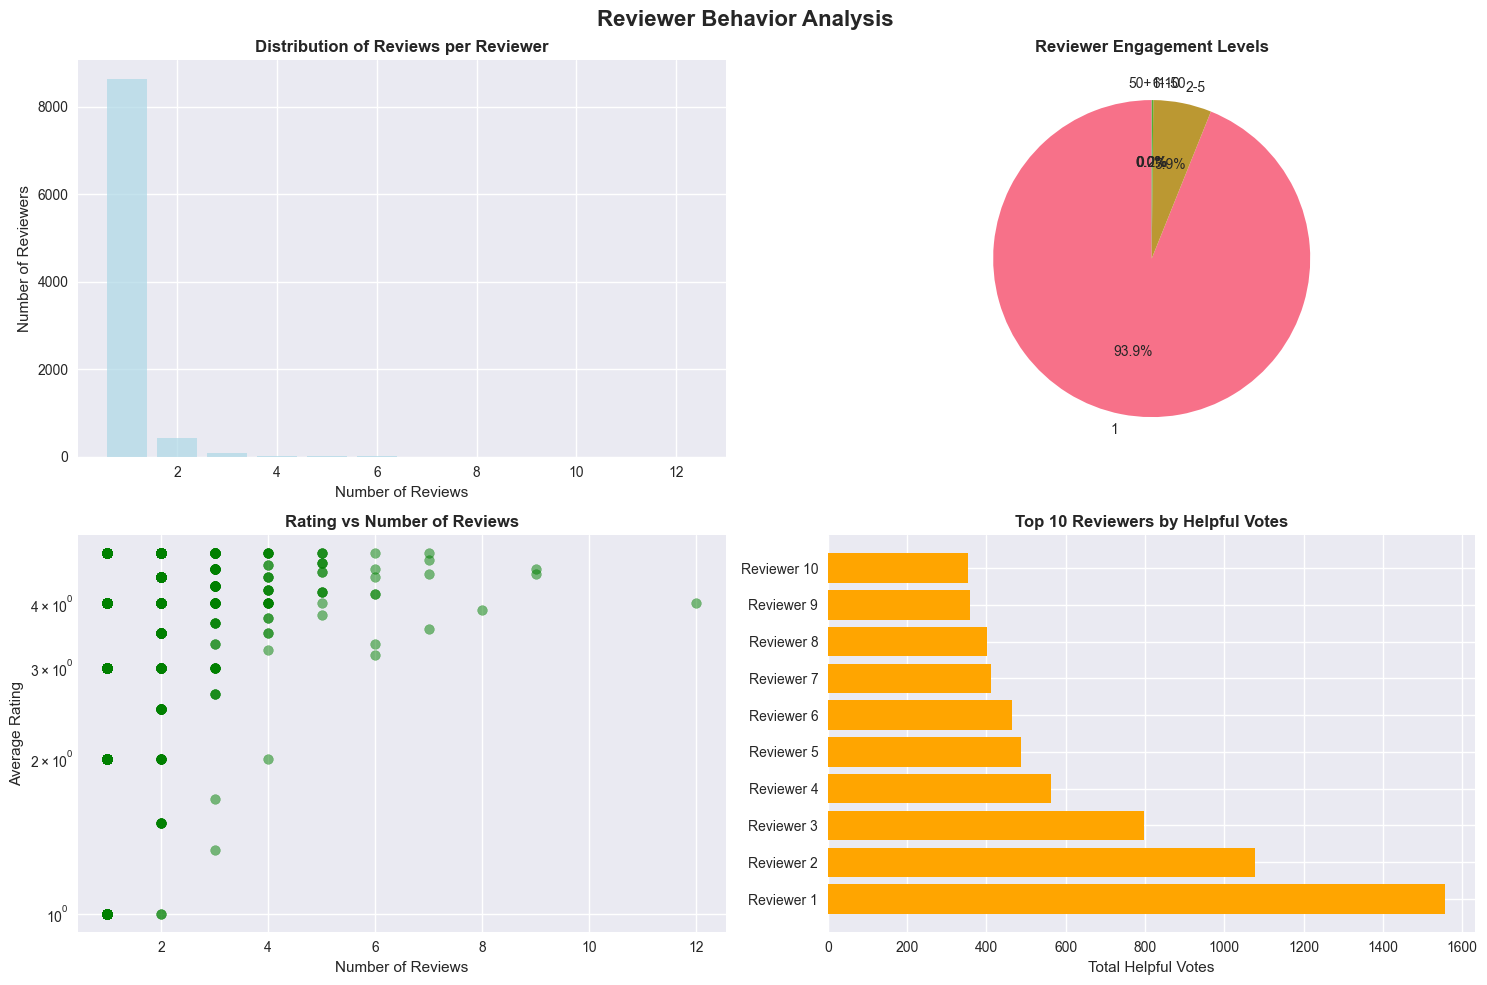


💡 REVIEWER INSIGHTS:
------------------------------
• Total unique reviewers: 9,188
• Average reviews per reviewer: 1.09
• Most active reviewer: 12 reviews
• Percentage of one-time reviewers: 93.9%


In [38]:
# Reviewer behavior analysis
def analyze_reviewer_behavior(df):
    """Analyze reviewer patterns and engagement"""
    
    print("👥 REVIEWER BEHAVIOR ANALYSIS")
    print("="*50)
    
    # Calculate reviewer statistics
    reviewer_stats = df.groupby('reviewerID').agg({
        'overall': ['count', 'mean'],
        'review_length': 'mean',
        'helpful': 'sum',
        'review_date': ['min', 'max']
    }).round(2)
    
    reviewer_stats.columns = ['review_count', 'avg_rating', 'avg_review_length', 'total_helpful', 'first_review', 'last_review']
    reviewer_stats = reviewer_stats.sort_values('review_count', ascending=False)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Reviewer Behavior Analysis', fontsize=16, fontweight='bold')
    
    # 1. Review count distribution
    review_count_dist = reviewer_stats['review_count'].value_counts().sort_index().head(20)
    axes[0,0].bar(review_count_dist.index, review_count_dist.values, color='lightblue', alpha=0.7)
    axes[0,0].set_title('Distribution of Reviews per Reviewer', fontweight='bold')
    axes[0,0].set_xlabel('Number of Reviews')
    axes[0,0].set_ylabel('Number of Reviewers')
    
    # 2. Reviewer engagement levels
    engagement_levels = pd.cut(reviewer_stats['review_count'], 
                              bins=[0, 1, 5, 10, 50, float('inf')],
                              labels=['1', '2-5', '6-10', '11-50', '50+'])
    engagement_dist = engagement_levels.value_counts()
    
    axes[0,1].pie(engagement_dist.values, labels=engagement_dist.index, autopct='%1.1f%%', startangle=90)
    axes[0,1].set_title('Reviewer Engagement Levels', fontweight='bold')
    
    # 3. Rating vs review count
    axes[1,0].scatter(reviewer_stats['review_count'], reviewer_stats['avg_rating'], 
                     alpha=0.5, color='green')
    axes[1,0].set_title('Rating vs Number of Reviews', fontweight='bold')
    axes[1,0].set_xlabel('Number of Reviews')
    axes[1,0].set_ylabel('Average Rating')
    axes[1,0].set_yscale('log')
    
    # 4. Top reviewers by helpful votes
    top_helpful = reviewer_stats.nlargest(10, 'total_helpful')
    axes[1,1].barh(range(len(top_helpful)), top_helpful['total_helpful'], color='orange')
    axes[1,1].set_yticks(range(len(top_helpful)))
    axes[1,1].set_yticklabels([f"Reviewer {i+1}" for i in range(len(top_helpful))])
    axes[1,1].set_title('Top 10 Reviewers by Helpful Votes', fontweight='bold')
    axes[1,1].set_xlabel('Total Helpful Votes')
    
    plt.tight_layout()
    plt.show()
    
    # Print insights
    print("\n💡 REVIEWER INSIGHTS:")
    print("-" * 30)
    print(f"• Total unique reviewers: {len(reviewer_stats):,}")
    print(f"• Average reviews per reviewer: {reviewer_stats['review_count'].mean():.2f}")
    print(f"• Most active reviewer: {reviewer_stats['review_count'].max()} reviews")
    print(f"• Percentage of one-time reviewers: {engagement_dist['1']/len(reviewer_stats)*100:.1f}%")
    
    return reviewer_stats

# Run reviewer analysis
if 'clean_df' in locals():
    reviewer_stats = analyze_reviewer_behavior(clean_df)

## 7. Category Analysis

📚 CATEGORY ANALYSIS


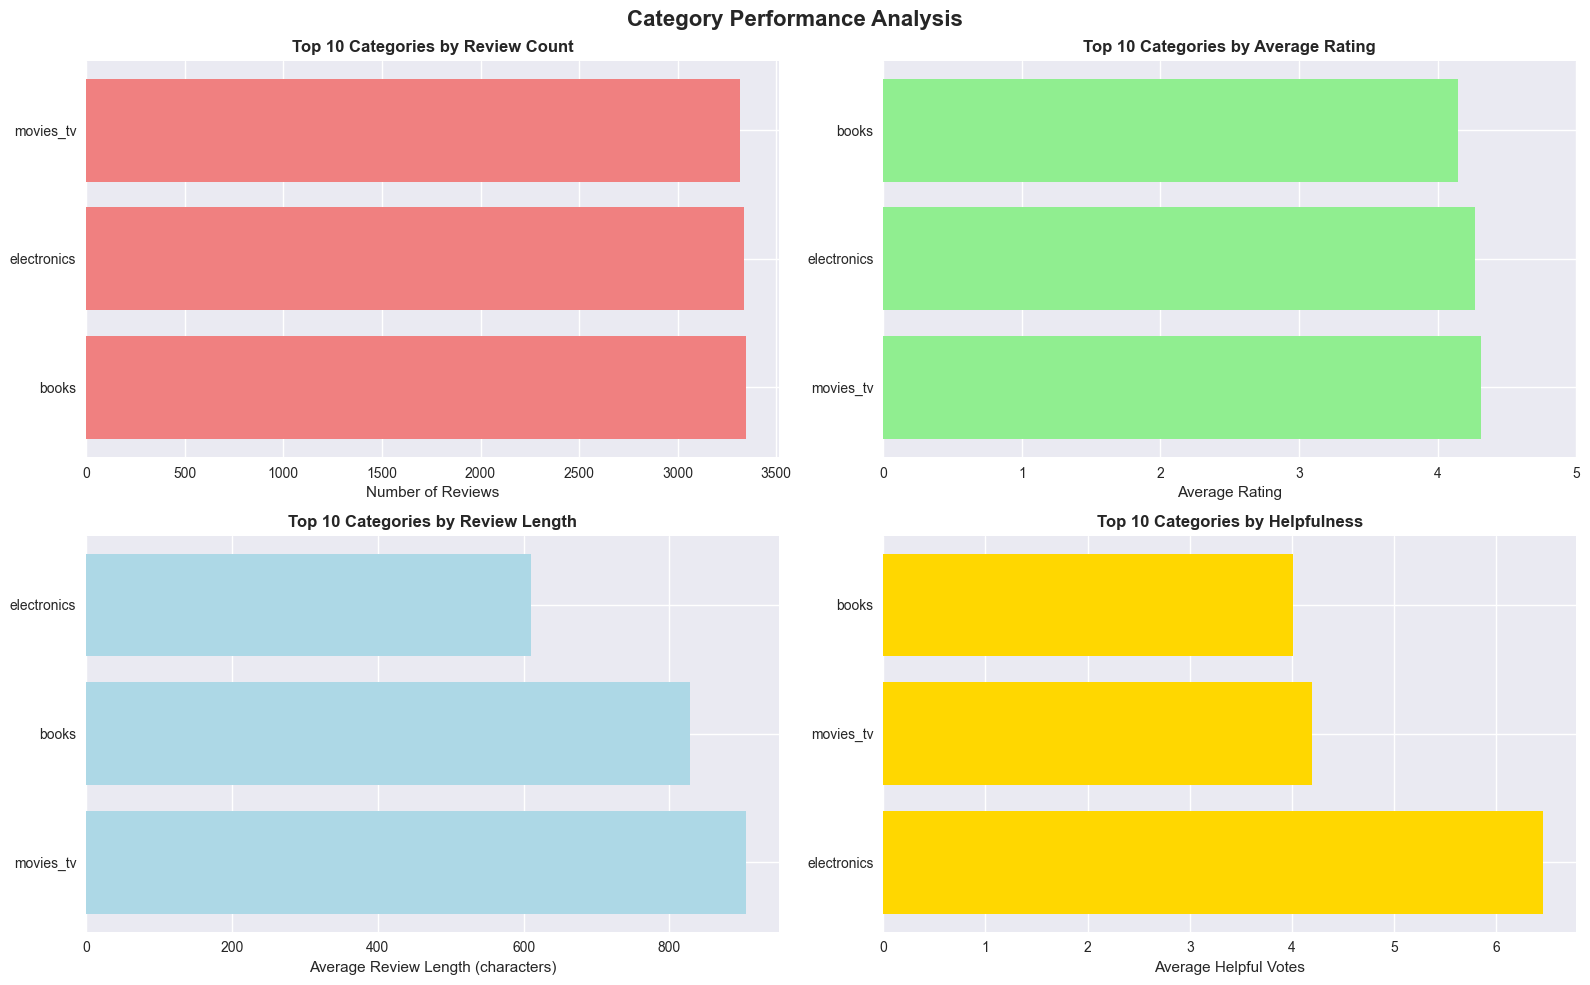


💡 CATEGORY INSIGHTS:
------------------------------
• Most reviewed category: books (3,346.0 reviews)
• Highest rated category: movies_tv (4.31)
• Most consistent ratings: movies_tv (std: 1.10)
• Longest reviews: movies_tv (905 chars)


In [39]:
# Category analysis
def analyze_categories(df):
    """Analyze performance across different categories"""
    
    print("📚 CATEGORY ANALYSIS")
    print("="*50)
    
    # Calculate category statistics
    category_stats = df.groupby('category').agg({
        'overall': ['count', 'mean', 'std'],
        'review_length': 'mean',
        'helpful': 'mean',
        'reviewerID': 'nunique'
    }).round(2)
    
    category_stats.columns = ['review_count', 'avg_rating', 'rating_std', 'avg_review_length', 'avg_helpful', 'unique_reviewers']
    category_stats = category_stats.sort_values('review_count', ascending=False)
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle('Category Performance Analysis', fontsize=16, fontweight='bold')
    
    # 1. Reviews by category
    top_categories = category_stats.head(10)
    axes[0,0].barh(top_categories.index, top_categories['review_count'], color='lightcoral')
    axes[0,0].set_title('Top 10 Categories by Review Count', fontweight='bold')
    axes[0,0].set_xlabel('Number of Reviews')
    
    # 2. Average rating by category
    rating_sorted = category_stats.sort_values('avg_rating', ascending=False).head(10)
    axes[0,1].barh(rating_sorted.index, rating_sorted['avg_rating'], color='lightgreen')
    axes[0,1].set_title('Top 10 Categories by Average Rating', fontweight='bold')
    axes[0,1].set_xlabel('Average Rating')
    axes[0,1].set_xlim(0, 5)
    
    # 3. Review length by category
    length_sorted = category_stats.sort_values('avg_review_length', ascending=False).head(10)
    axes[1,0].barh(length_sorted.index, length_sorted['avg_review_length'], color='lightblue')
    axes[1,0].set_title('Top 10 Categories by Review Length', fontweight='bold')
    axes[1,0].set_xlabel('Average Review Length (characters)')
    
    # 4. Helpfulness by category
    helpful_sorted = category_stats.sort_values('avg_helpful', ascending=False).head(10)
    axes[1,1].barh(helpful_sorted.index, helpful_sorted['avg_helpful'], color='gold')
    axes[1,1].set_title('Top 10 Categories by Helpfulness', fontweight='bold')
    axes[1,1].set_xlabel('Average Helpful Votes')
    
    plt.tight_layout()
    plt.show()
    
    # Print insights
    print("\n💡 CATEGORY INSIGHTS:")
    print("-" * 30)
    print(f"• Most reviewed category: {category_stats.index[0]} ({category_stats.iloc[0]['review_count']:,} reviews)")
    print(f"• Highest rated category: {category_stats['avg_rating'].idxmax()} ({category_stats['avg_rating'].max():.2f})")
    print(f"• Most consistent ratings: {category_stats['rating_std'].idxmin()} (std: {category_stats['rating_std'].min():.2f})")
    print(f"• Longest reviews: {category_stats['avg_review_length'].idxmax()} ({category_stats['avg_review_length'].max():.0f} chars)")
    
    return category_stats

# Run category analysis
if 'clean_df' in locals():
    category_stats = analyze_categories(clean_df)

## 8. Advanced Analysis: Helpfulness and Review Length

🔍 ADVANCED ANALYSIS


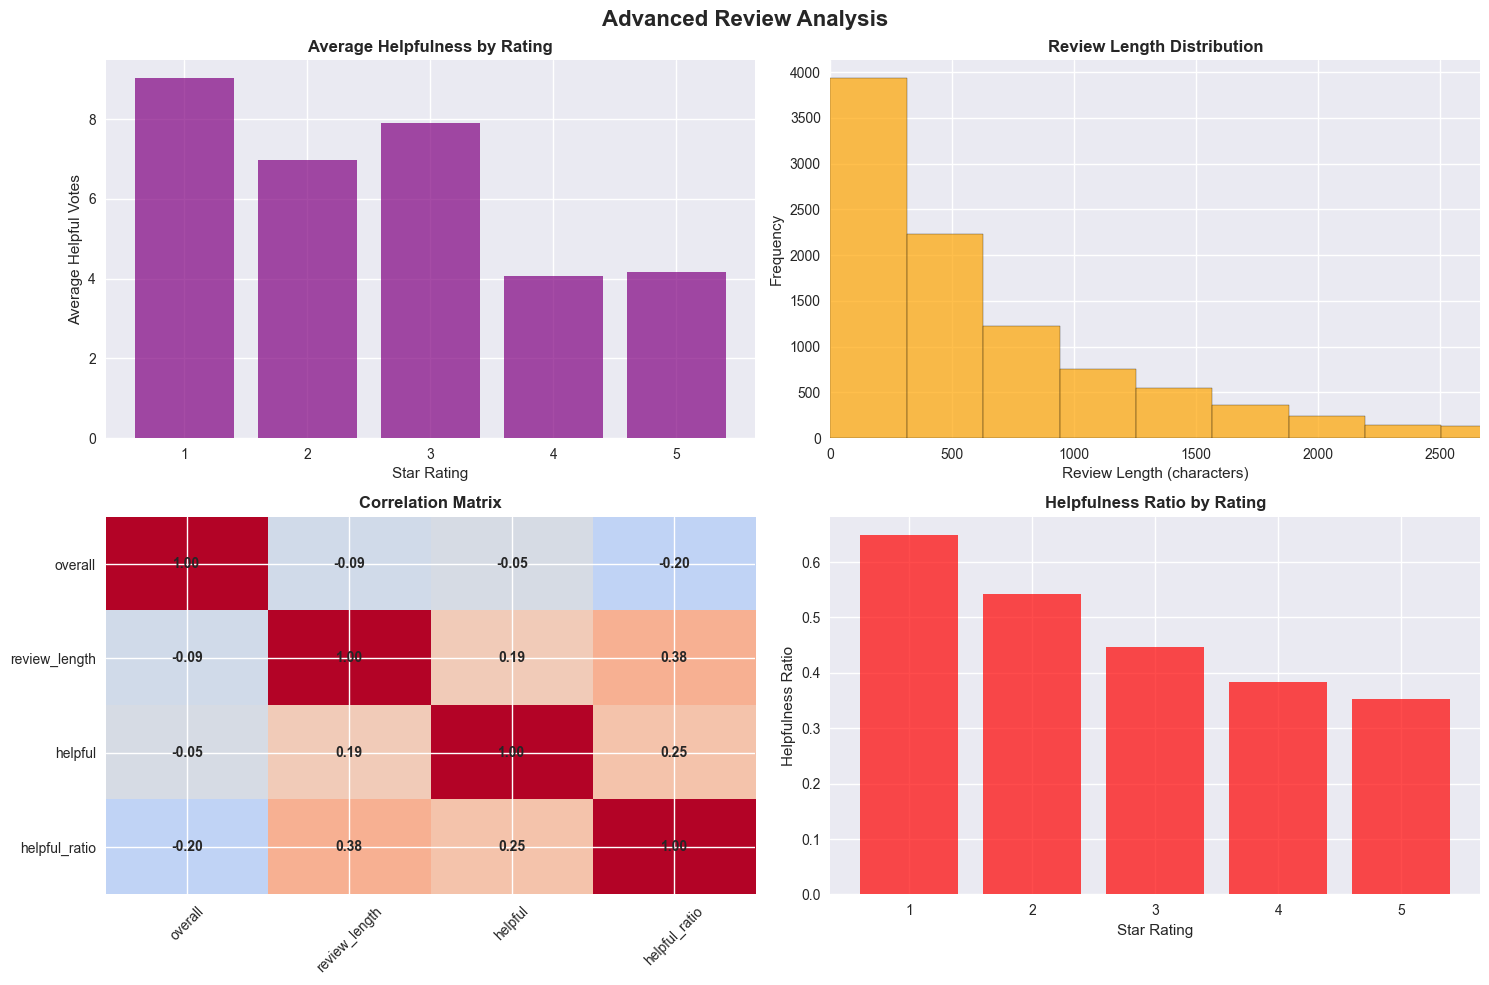


💡 ADVANCED INSIGHTS:
------------------------------
• Correlation rating-helpfulness: -0.051
• Correlation rating-length: -0.092
• Average review length: 781 characters
• Most helpful rating: 1.0 stars


In [40]:
# Advanced analysis
def advanced_analysis(df):
    """Advanced analysis of review characteristics"""
    
    print("🔍 ADVANCED ANALYSIS")
    print("="*50)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Advanced Review Analysis', fontsize=16, fontweight='bold')
    
    # 1. Helpfulness vs rating
    helpful_by_rating = df.groupby('overall')['helpful'].mean()
    axes[0,0].bar(helpful_by_rating.index, helpful_by_rating.values, color='purple', alpha=0.7)
    axes[0,0].set_title('Average Helpfulness by Rating', fontweight='bold')
    axes[0,0].set_xlabel('Star Rating')
    axes[0,0].set_ylabel('Average Helpful Votes')
    axes[0,0].set_xticks(range(1, 6))
    
    # 2. Review length distribution
    axes[0,1].hist(df['review_length'], bins=50, color='orange', alpha=0.7, edgecolor='black')
    axes[0,1].set_title('Review Length Distribution', fontweight='bold')
    axes[0,1].set_xlabel('Review Length (characters)')
    axes[0,1].set_ylabel('Frequency')
    axes[0,1].set_xlim(0, df['review_length'].quantile(0.95))  # Remove extreme outliers
    
    # 3. Correlation heatmap
    numeric_cols = ['overall', 'review_length', 'helpful', 'helpful_ratio']
    correlation_matrix = df[numeric_cols].corr()
    
    im = axes[1,0].imshow(correlation_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
    axes[1,0].set_xticks(range(len(numeric_cols)))
    axes[1,0].set_yticks(range(len(numeric_cols)))
    axes[1,0].set_xticklabels(numeric_cols, rotation=45)
    axes[1,0].set_yticklabels(numeric_cols)
    axes[1,0].set_title('Correlation Matrix', fontweight='bold')
    
    # Add correlation values
    for i in range(len(numeric_cols)):
        for j in range(len(numeric_cols)):
            axes[1,0].text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}', 
                          ha='center', va='center', fontweight='bold')
    
    # 4. Helpfulness ratio by rating
    helpful_ratio_by_rating = df.groupby('overall')['helpful_ratio'].mean()
    axes[1,1].bar(helpful_ratio_by_rating.index, helpful_ratio_by_rating.values, color='red', alpha=0.7)
    axes[1,1].set_title('Helpfulness Ratio by Rating', fontweight='bold')
    axes[1,1].set_xlabel('Star Rating')
    axes[1,1].set_ylabel('Helpfulness Ratio')
    axes[1,1].set_xticks(range(1, 6))
    
    plt.tight_layout()
    plt.show()
    
    # Print insights
    print("\n💡 ADVANCED INSIGHTS:")
    print("-" * 30)
    print(f"• Correlation rating-helpfulness: {df['overall'].corr(df['helpful']):.3f}")
    print(f"• Correlation rating-length: {df['overall'].corr(df['review_length']):.3f}")
    print(f"• Average review length: {df['review_length'].mean():.0f} characters")
    print(f"• Most helpful rating: {helpful_by_rating.idxmax()} stars")
    
    return correlation_matrix

# Run advanced analysis
if 'clean_df' in locals():
    correlation_matrix = advanced_analysis(clean_df)

## 9 Sentiment Analysis

🧠 SENTIMENT ANALYSIS
Analyzing sentiment for 500 reviews...


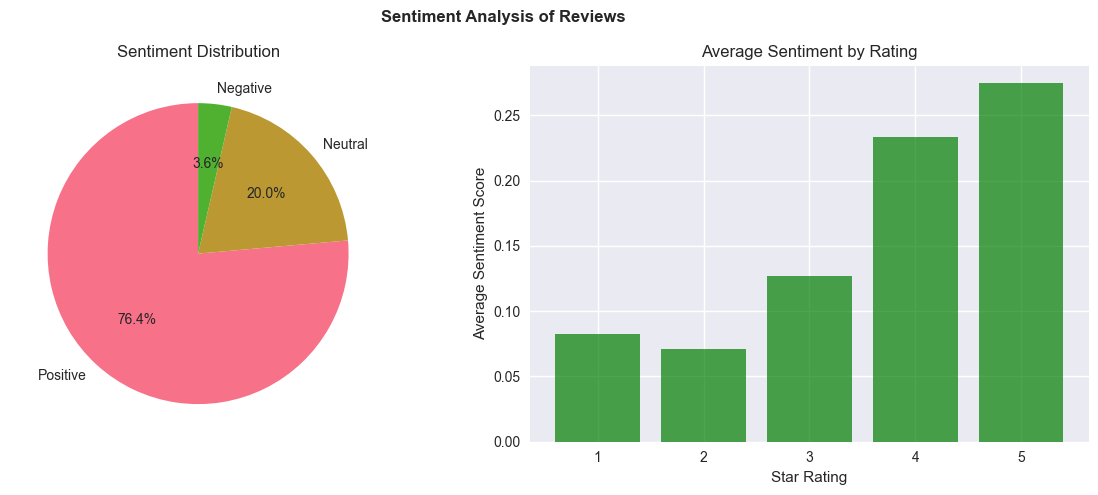


💡 SENTIMENT INSIGHTS:
------------------------------
• Sentiment-Rating Correlation: 0.327
• Average Sentiment Score: 0.232
• Positive Reviews: 382
• Negative Reviews: 18


In [41]:
# Sentiment Analysis (requires textblob)
try:
    from textblob import TextBlob
    
    def analyze_sentiment(df, sample_size=500):
        """Perform sentiment analysis on review text"""
        
        print("🧠 SENTIMENT ANALYSIS")
        print("="*50)
        
        # Sample reviews for analysis (to save time)
        sample_df = df[df['reviewText'].notna()].sample(min(sample_size, len(df)))
        
        print(f"Analyzing sentiment for {len(sample_df)} reviews...")
        
        # Calculate sentiment polarity
        sample_df['sentiment'] = sample_df['reviewText'].apply(
            lambda x: TextBlob(str(x)).sentiment.polarity
        )
        
        # Categorize sentiment
        sample_df['sentiment_label'] = sample_df['sentiment'].apply(
            lambda x: 'Positive' if x > 0.1 else 'Negative' if x < -0.1 else 'Neutral'
        )
        
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        fig.suptitle('Sentiment Analysis of Reviews', fontweight='bold')
        
        # 1. Sentiment distribution
        sentiment_dist = sample_df['sentiment_label'].value_counts()
        axes[0].pie(sentiment_dist.values, labels=sentiment_dist.index, autopct='%1.1f%%', startangle=90)
        axes[0].set_title('Sentiment Distribution')
        
        # 2. Sentiment vs rating
        sentiment_by_rating = sample_df.groupby('overall')['sentiment'].mean()
        axes[1].bar(sentiment_by_rating.index, sentiment_by_rating.values, color='green', alpha=0.7)
        axes[1].set_title('Average Sentiment by Rating')
        axes[1].set_xlabel('Star Rating')
        axes[1].set_ylabel('Average Sentiment Score')
        axes[1].set_xticks(range(1, 6))
        
        plt.tight_layout()
        plt.show()
        
        # Correlation analysis
        correlation = sample_df['overall'].corr(sample_df['sentiment'])
        print(f"\n💡 SENTIMENT INSIGHTS:")
        print("-" * 30)
        print(f"• Sentiment-Rating Correlation: {correlation:.3f}")
        print(f"• Average Sentiment Score: {sample_df['sentiment'].mean():.3f}")
        print(f"• Positive Reviews: {len(sample_df[sample_df['sentiment_label'] == 'Positive'])}")
        print(f"• Negative Reviews: {len(sample_df[sample_df['sentiment_label'] == 'Negative'])}")
        
        return sample_df
    
    # Run sentiment analysis
    if 'clean_df' in locals():
        sentiment_df = analyze_sentiment(clean_df, 500)
        
except ImportError:
    print("❌ TextBlob not installed. Skipping sentiment analysis.")
    print("💡 Install with: pip install textblob")

## Summary and Key Findings

In [42]:
# Summary and key findings
def generate_summary(df):
    """Generate comprehensive summary of findings"""
    
    print("📊 COMPREHENSIVE SUMMARY")
    print("="*60)
    
    # Key metrics
    total_reviews = len(df)
    total_products = df['asin'].nunique()
    total_reviewers = df['reviewerID'].nunique()
    avg_rating = df['overall'].mean()
    
    # Rating distribution
    rating_dist = df['overall'].value_counts().sort_index()
    five_star_pct = (rating_dist[5] / total_reviews) * 100
    one_star_pct = (rating_dist[1] / total_reviews) * 100
    
    # Reviewer engagement
    reviewer_stats = df.groupby('reviewerID').size()
    single_reviewers = (reviewer_stats == 1).sum()
    single_reviewer_pct = (single_reviewers / total_reviewers) * 100
    
    # Category performance
    category_stats = df.groupby('category')['overall'].agg(['mean', 'count']).sort_values('count', ascending=False)
    best_category = category_stats['mean'].idxmax()
    worst_category = category_stats['mean'].idxmin()
    
    print("🎯 KEY METRICS:")
    print("-" * 30)
    print(f"• Total Reviews: {total_reviews:,}")
    print(f"• Unique Products: {total_products:,}")
    print(f"• Unique Reviewers: {total_reviewers:,}")
    print(f"• Average Rating: {avg_rating:.2f}/5.0")
    
    print("\n⭐ RATING INSIGHTS:")
    print("-" * 30)
    print(f"• 5-Star Reviews: {five_star_pct:.1f}%")
    print(f"• 1-Star Reviews: {one_star_pct:.1f}%")
    print(f"• Most Common Rating: {rating_dist.idxmax()} stars")
    
    print("\n👥 REVIEWER INSIGHTS:")
    print("-" * 30)
    print(f"• Single-Review Reviewers: {single_reviewer_pct:.1f}%")
    print(f"• Average Reviews per Reviewer: {reviewer_stats.mean():.2f}")
    print(f"• Most Active Reviewer: {reviewer_stats.max()} reviews")
    
    print("\n📚 CATEGORY INSIGHTS:")
    print("-" * 30)
    print(f"• Most Reviewed Category: {category_stats.index[0]}")
    print(f"• Highest Rated Category: {best_category} ({category_stats['mean'].max():.2f})")
    print(f"• Lowest Rated Category: {worst_category} ({category_stats['mean'].min():.2f})")
    
    print("\n💡 BUSINESS IMPLICATIONS:")
    print("-" * 30)
    print("• High percentage of 5-star reviews indicates generally satisfied customers")
    print("• Significant number of one-time reviewers suggests opportunity for engagement")
    print("• Category performance variations highlight areas for product improvement")
    print("• Review length and helpfulness correlations can guide review quality initiatives")

# Generate final summary
if 'clean_df' in locals():
    generate_summary(clean_df)
    
print("\n" + "="*60)
print("🎉 AMAZON EDA ANALYSIS COMPLETE!")
print("="*60)
print("Thank you for exploring the Amazon reviews dataset!")
print("Key visualizations and insights have been generated.")

📊 COMPREHENSIVE SUMMARY
🎯 KEY METRICS:
------------------------------
• Total Reviews: 10,000
• Unique Products: 713
• Unique Reviewers: 9,188
• Average Rating: 4.24/5.0

⭐ RATING INSIGHTS:
------------------------------
• 5-Star Reviews: 59.5%
• 1-Star Reviews: 5.2%
• Most Common Rating: 5.0 stars

👥 REVIEWER INSIGHTS:
------------------------------
• Single-Review Reviewers: 93.9%
• Average Reviews per Reviewer: 1.09
• Most Active Reviewer: 12 reviews

📚 CATEGORY INSIGHTS:
------------------------------
• Most Reviewed Category: books
• Highest Rated Category: movies_tv (4.31)
• Lowest Rated Category: books (4.15)

💡 BUSINESS IMPLICATIONS:
------------------------------
• High percentage of 5-star reviews indicates generally satisfied customers
• Significant number of one-time reviewers suggests opportunity for engagement
• Category performance variations highlight areas for product improvement
• Review length and helpfulness correlations can guide review quality initiatives

🎉 AMAZO